# Data loading and preprocessing, utility function definition

## Imports and data loading

In [1]:
import gc
import itertools
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# A few functions are imported from a utility script
import futuresalesutility as fu

Load the data and convert the date column in the training data to the datetime dtype to enable datetime operations.

In [2]:
item_categories_extra = pd.read_csv('../input/predict-future-sales-extra/item_categories_enhanced.csv')
item_categories_extra = item_categories_extra.drop(columns=['category_name', 'supercategory', 'platform'])
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

* Correct duplicate shop names
* Drop a few duplicate items in the training set
* Drop shops which are not in the test set (these are only a few of these and they tend to be strange in some way, e.g. low sales, not operating for long)+
* Drop categories 8 and 80 as these are for tickets to an annual exhibition which are not sold in the test month
* Remove outliers and negative values for the item_cnt_day and item_price features (these are few in number but cause problems when generating some features)

In [3]:
# Correct shop labels
train.loc[train.shop_id == 0, "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
# Drop shops not in test set
testshops = test.shop_id.unique()
train = train.loc[train["shop_id"].isin(testshops), :]
del testshops
# Drop duplicates
train = train.drop_duplicates()
# Drop categories 8 and 80
train = train.merge(items[["item_id", "item_category_id"]], on="item_id", how="left")
train = train[~train.item_category_id.isin([8, 80])]
# Clip outliers and  remove items with a negative sales price or item_cnt_day
train = train.query("(item_price>0) & (item_cnt_day>0)")
train.loc[:, "item_price"] = train.loc[:, "item_price"].clip(0, train["item_price"].quantile(0.9999))
train.loc[:, "item_cnt_day"] = train.loc[:, "item_cnt_day"].clip(0, train["item_cnt_day"].quantile(0.999))

## Preprocessing

Create a training matrix similar to the test items by aggregating the sales to the month level and creating items for every possible combination of shops and items featured in each individual month of the training data. Additionally, concatenate test to train data to enable creation of features for the test items.

In [4]:
def create_testlike_train(sales_train, test=None):
    # Create a date_block_num / item_id / shop_id index using all combinations of item_id and shop_id occurring within each date_block
    # Optionally concatenate the test items to the end
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0), columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],)

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [5]:
matrix = create_testlike_train(train, test)
del(test)
matrix = fu.reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.26 MB
Memory usage after optimization is: 151.97 MB
Decreased by 62.5%


# Feature engineering  
In this section predictor feature columns are generated and added to the matrix

## Item name groups discovered by name matching with fuzzywuzzy

Items in the items table are ordered alphabetically according to the item_name field, so that similar items are generally listed next to each other. This ordering can be used to help group related items together, which could perhaps help share information between items.  

The following cell groups similar items together by using the sting matching algorithm fuzzywuzzy (https://github.com/seatgeek/fuzzywuzzy) is used to measure the similarity of each item to the item preceding it in the items table, then grouping adjacent items into groups unless the similarity score is below a threshold value.

In [6]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


In [7]:
import re

from fuzzywuzzy import fuzz

def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string
        
        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train

matrix, train = add_item_name_groups(matrix, train, items, 65)

## Music artist extraction or first word of item name  

The "item_name" field of items in the music categories typically begin with the artist's name marked with one of three patterns: either all uppercase, separated from the release title by a doublespace, or separated by dot-space (. ). Regex expressions are used to extract artist names from music categories using these rules. For non-music categories, the first word in the name is extracted instead.  

This feature adds a more general grouping to the preceding item name group features

In [15]:
from nltk.corpus import stopwords

def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[items.item_category_id.isin(music_categories), "item_name"].apply(
        extract_artist
    )
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[~items.item_category_id.isin(music_categories), "item_name"].apply(
        first_word
    )
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix

matrix = add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word")

## Item name length as a feature
Surprisingly predictive

In [9]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [13]:
print("Created name features")
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)

Created name features


## Time features
Time-dependent features
* Item and shop age in months
* Binary features for new items and shops (i.e. first month of appearance)
* Item and shop age in days
* Number of days in the current month
* Average item count per day in the last month - useful for new items which may not have been available for the full calendar month
* Days since last sale of an item in each shop and all shops

In [14]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(lambda x: x - x.min())
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = m.groupby("shop_id")["date_block_num"].transform(lambda x: x - x.min()).astype("int8")
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,)
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    first_item_name_group_date = train.groupby("item_name_group").date.min().rename("first_name_group_date")
    first_shop_item_name_group_date = train.groupby(["shop_id", "item_name_group"]).date.min().rename("first_shop_name_group_date")

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left")
    m = m.merge(first_item_name_group_date, left_on="item_name_group", right_index=True, how="left")
    m = m.merge(first_shop_item_name_group_date, left_on=["shop_id", "item_name_group"], right_index=True, how="left")

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["first_shop_name_group_sale_days"] = m["month_first_day"] - m["first_shop_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0,9999)
    m["first_shop_item_sale_days"] = m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0,9999)
    m["first_name_group_sale_days"] = m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0,9999)
    m["first_shop_name_group_sale_days"] = m["first_shop_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0,9999)

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        last_item_dates = []
        last_shop_name_group_dates = []
        last_name_group_dates = []
        for dbn in range(1, 35):
            lsid_temp = train.query(f"date_block_num<{dbn}").groupby(["shop_id", "item_id"]).date.max().rename("last_shop_item_sale_date").reset_index()
            lid_temp = lsid_temp.groupby("item_id").last_shop_item_sale_date.max().rename("last_item_sale_date").reset_index()
            lsid_temp["date_block_num"] = dbn
            lid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)
            last_item_dates.append(lid_temp)
            
            lsngd_temp = train.query(f"date_block_num<{dbn}").groupby(["shop_id", "item_name_group"]).date.max().rename("last_shop_name_group_sale_date").reset_index()
            lngd_temp = lsngd_temp.groupby("item_name_group").last_shop_name_group_sale_date.max().rename("last_name_group_sale_date").reset_index()
            lsngd_temp["date_block_num"] = dbn
            lngd_temp["date_block_num"] = dbn
            last_shop_name_group_dates.append(lsngd_temp)
            last_name_group_dates.append(lngd_temp)
            
        last_shop_item_dates = pd.concat(last_shop_item_dates)
        last_item_dates = pd.concat(last_item_dates)
        matrix = matrix.merge(last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left")
        matrix = matrix.merge(last_item_dates, on=["date_block_num", "item_id"], how="left")
        
        last_shop_name_group_dates = pd.concat(last_shop_name_group_dates)
        last_name_group_dates = pd.concat(last_name_group_dates)
        matrix = matrix.merge(last_shop_name_group_dates, on=["date_block_num", "shop_id", "item_name_group"], how="left")
        matrix = matrix.merge(last_name_group_dates, on=["date_block_num", "item_name_group"], how="left")

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999)
        matrix = days_since_last_feat(matrix, "last_item_sale_days", "last_item_sale_date", 9999)
        
        matrix = days_since_last_feat(matrix, "last_shop_name_group_sale_days", "last_shop_name_group_sale_date", 9999)
        matrix = days_since_last_feat(matrix, "last_name_group_sale_days", "last_name_group_sale_date", 9999)
        
        matrix = matrix.drop(columns=["last_shop_item_sale_date", "last_item_sale_date", "last_shop_name_group_sale_date", "last_name_group_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "first_shop_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length"
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [15]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


Clip the monthly item counts to match the test set

In [16]:
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(lower=0, upper=20)

## Price features  
* Last mean price for a month in which the item was sold
* Difference of the last price from the historical mean (calculated with an expanding window)
* Difference of the last mean price from the first sale price in the data (proxy for the release price)
* Difference of the last mean price from the mean for the category in the same month.  

It can be assumed that item price is related to sales, both in absolute terms and relative to other items of the same category and the same item's earlier price.

In [18]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [20]:
matrix = add_price_features(matrix, train)
del(train)

## Categorical features

Categorical features provided with the data, e.g. item category, and custom categories extracted from category and shop names, e.g. "video games", "music", "PS4"

In [21]:
matrix = matrix.merge(items.drop(columns='item_name'), on='item_id', how='left')
matrix = matrix.merge(item_categories_extra, on='item_category_id', how='left')
del(item_categories_extra)

City that the shop is located in
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [23]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

## Shop sales profile clustering

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

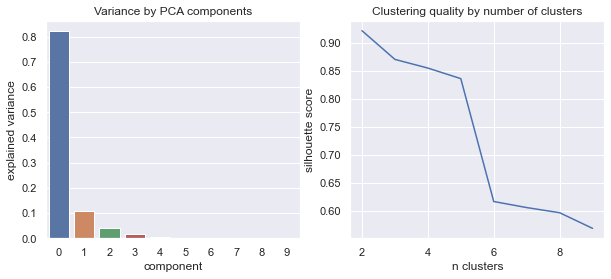

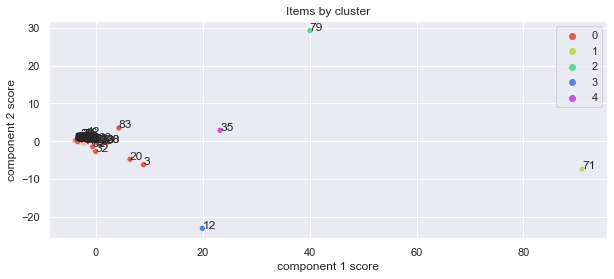

In [25]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=3, n_clusters=5, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

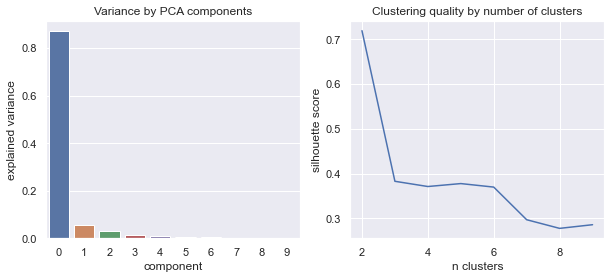

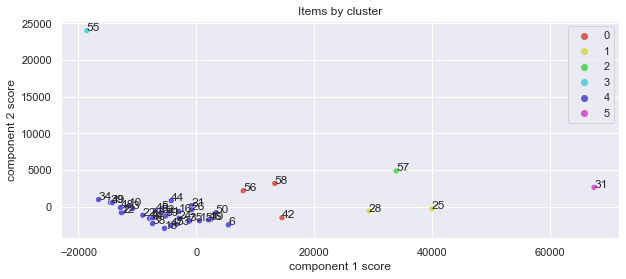

In [26]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=6, aggfunc="sum", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [27]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory
matrix.to_pickle("matrixcheckpoint_1.pkl")
print("Saved matrixcheckpoint 1")

Saved matrixcheckpoint 1


## Number of unique item features  
i.e. counts of new and unique items in the current month  
This counts the number of unique and new items sold in the current month and also category, which could have a positive relationship to sales. As this can also be calculated for the test set (assuming that the set of test items is the set of items that were sold in the test month) this is a kind of data leak. 

In [54]:
matrix = uniques(matrix, ["date_block_num", "item_category_id"], "new_items_cat", limitation="new_item==True")

In [31]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = matrix.query(limitation).groupby(groupers).item_id.nunique().rename(name).reset_index()
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how='left')
    matrix[name] = matrix[name].fillna(0)
    return matrix

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(matrix, ["date_block_num", "item_category_id", "item_name_group"], "name_group_cat_unique_month")
matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_new_unique_month", limitation="new_item==True")
matrix = uniques(matrix, ["date_block_num", "item_category_id", "item_name_group"], "name_group_new_cat_unique_month", limitation="new_item==True")

matrix = uniques(matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month")
matrix = uniques(matrix, ["date_block_num", "item_category_id", "artist_name_or_first_word"], "first_word_cat_unique_month")
matrix = uniques(matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_new_unique_month", limitation="new_item==True")
matrix = uniques(matrix, ["date_block_num", "item_category_id", "artist_name_or_first_word"], "first_word_new_cat_unique_month", limitation="new_item==True")
# Following is new feature to be tested
matrix["name_group_new_proportion_month"] = matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
matrix["first_word_new_proportion_month"] = matrix["first_word_new_unique_month"] / matrix["first_word_unique_month"]

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(matrix, ["date_block_num"], "unique_items_month")
matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

In [33]:
matrix = matrix.drop(columns=['unique_items_month', 'name_group_unique_month'])

In [34]:
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)

## Percentage change in an aggregate feature over a specified period  
e.g. change in total shop revenue compared to the previous month

In [35]:
def add_pct_change(matrix, group_feats, target="item_cnt_month", aggfunc="mean", periods=1, lag=1, clip_value=None):
    periods = fu.list_if_not(periods, int)
    group_feats = fu.list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(index=group_feats + ["date_block_num"], values=target, aggfunc=aggfunc, fill_value=0, dropna=False).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float("nan")
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"])
        print(f"Adding feature {feat_name}")
        dat = dat.groupby(group_feats)[target].transform(lambda x: x.pct_change(periods=period, fill_method="pad")).rename(feat_name)
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = fu.reduce_mem_usage(matrix[feat_name])
    return matrix

In [36]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 features lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


In [37]:
matrix.to_pickle("matrixcheckpoint_2.pkl")
print("Saved matrixcheckpoint 2")

Saved matrixcheckpoint 2


## Rolling mean features
Sales from previous months are a good predictor of future sales, but chance fluctuations mean that an average of several previous months may be more reliable than counts from a single month. Pandas has several windowing functions for time series built in, 3 of which are demonstrated below : expanding (all previous timepoints), rolling (a fixed number of previous timepoints) and exponential (a weighted window with weights which decrease with time distance before the current point). These are compared below.

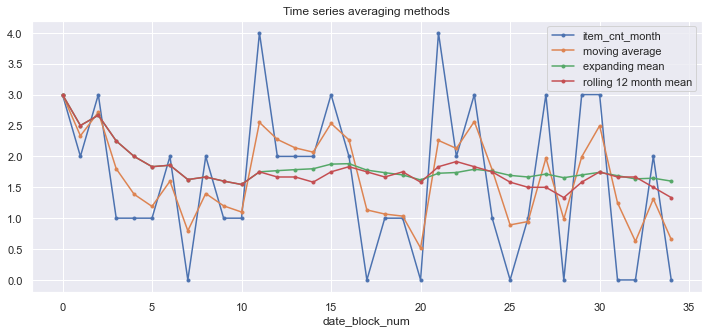

In [39]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [96]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    # General purpose windowed aggregation function
    def rolling_stat(matrix, source, feats, feat_name, window=12, argfeat="item_cnt_month", aggfunc="mean", dtype=dtype, lag_offset=0):
        # Calculate a statistic on a windowed section of a source table grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = source.loc[source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat].agg(aggfunc).astype(dtype)
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    # The reshaped source aggregates features at the month level, fills in missing months with zeros and sets months before the feature level's first appearance to nan
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(index=features + ["date_block_num"], values=argfeat, aggfunc=aggfunc, fill_value=0, dropna=False).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            source.loc[source.index.get_level_values("date_block_num") < source["firsts"], argfeat] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(matrix, source, features, feat_name, window=window, argfeat=argfeat, aggfunc=rolling_aggfunc, dtype=dtype, lag_offset=lag_offset)
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(matrix, source, features, feat_name, window=100, argfeat=argfeat, aggfunc=aggfunc, dtype=dtype, lag_offset=lag_offset)
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = source.groupby(features)[argfeat].ewm(halflife=window, min_periods=1).agg(rolling_aggfunc).to_numpy(dtype=dtype)
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

Implement rolling mean / median / minimum / maximum features.

In [42]:
# Testing platform_id and supercategory features
matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["supercategory_id"], window=12)

matrix = add_rolling_stats(matrix, ["shop_id", "platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "supercategory_id"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["supercategory_id"], kind="ewm", window=1)

matrix = add_rolling_stats(matrix, ["shop_id", "platform_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "supercategory_id"], kind="ewm", window=1)

matrix = add_rolling_stats(matrix, ["shop_id", "platform_id", "new_item"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False)

matrix = add_rolling_stats(matrix, ["shop_id", "platform_id", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "supercategory_id", "item_age"], window=12, reshape_source=False)

Creating feature "platform_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "supercategory_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_platform_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_supercategory_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "platform_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "supercategory_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_platform_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_supercategory_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_platform_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_supercategory_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_platform_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_supercategory_item_age_item_cnt_month_mean_rolling_mean_win_12"


In [43]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory
matrix.to_pickle("matrixcheckpoint_3.pkl")
print("Saved matrixcheckpoint 3")

Saved matrixcheckpoint 3


In [44]:
# Versions with default target
matrix = add_rolling_stats(matrix, ["category_cluster"], window=12)
matrix = add_rolling_stats(matrix, ["category_cluster", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["category_cluster", "new_item"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_id"], kind="expanding")

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word", "item_category_id", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False)

matrix = add_rolling_stats(matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="expanding")
matrix = add_rolling_stats(matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False)

matrix = add_rolling_stats(matrix, ["item_name_group", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_name_group", "item_category_id", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="expanding")
matrix = add_rolling_stats(matrix, ["item_name_group", "new_item"], window=12, reshape_source=False)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_cluster", "item_category_id", "item_age"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False)

matrix = add_rolling_stats(matrix, ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id", "item_age"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id", "new_item"], kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_name_group", "item_category_id", "new_item"], window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False)

Creating feature "category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "category_cluster_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "category_cluster_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "category_cluster_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "category_cluster_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "item_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_mean_expanding_mean"
Creating feature "artist_name_or_first_word_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "artist_name_or_first_word_item_cnt_month_mean_ewm_hl_1"
Creating feature "artist_name_or_first_word_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating fea

In [45]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_4.pkl")
print("Saved matrixcheckpoint 4")

Saved matrixcheckpoint 4


The following code block calculates windowed mean sales features with day resolution accuracy

In [46]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="rolling", window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="rolling", window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="expanding", reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="expanding", reshape_source=False)
matrix["1year"] = 365
matrix["shop_id_item_id_day_mean_win_12"] = (
    matrix["shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
)
matrix["item_id_day_mean_win_12"] = (
    matrix["item_id_item_cnt_month_sum_rolling_sum_win_12"] / matrix[["first_item_sale_days", "1year"]].min(axis=1)
)
matrix["shop_id_item_id_day_mean_expanding"] = (
    matrix["shop_id_item_id_item_cnt_month_sum_expanding_sum"] / matrix[["first_item_sale_days", "shop_open_days"]].min(axis=1)
)
matrix["item_id_day_mean_expanding"] = (matrix["item_id_item_cnt_month_sum_expanding_sum"] / matrix[["first_item_sale_days"]].min(axis=1))
matrix.loc[
    matrix.new_item == True,
    ["shop_id_item_id_day_mean_win_12", "item_id_day_mean_win_12", "shop_id_item_id_day_mean_expanding", "item_id_day_mean_expanding"],
] = float('nan')
del matrix["1year"]

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


In [46]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="rolling", window=12, reshape_source=False)
matrix = add_rolling_stats(matrix, ["item_id"], aggfunc="sum", rolling_aggfunc="sum", kind="expanding", reshape_source=False)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = (matrix["item_id_item_cnt_month_sum_expanding_sum"] / matrix[["first_item_sale_days"]].min(axis=1))
matrix["shop_id_item_id_day_mean_win_12"] = (
    matrix["shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
)
matrix.loc[
    matrix.new_item == True,
    "item_id_day_mean_expanding",
] = float('nan')
matrix = matrix.drop(columns=['1year', "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


Expanding sum features

In [47]:
matrix = add_rolling_stats(matrix, ["shop_id", "item_name_group"], aggfunc="sum", rolling_aggfunc="sum", kind="expanding")
matrix = add_rolling_stats(matrix, ["item_name_group"], aggfunc="sum", rolling_aggfunc="sum", kind="expanding")

Creating feature "shop_id_item_name_group_item_cnt_month_sum_expanding_sum"
Creating feature "item_name_group_item_cnt_month_sum_expanding_sum"


Revenue features

In [98]:
matrix = add_rolling_stats(matrix, ["shop_id", "item_name_group"], window=12, argfeat="item_revenue_month", dtype="float32")

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


New item features

In [56]:
matrix = add_rolling_stats(matrix, ["item_category_id"], argfeat="new_items_cat", window=12, reshape_source=True, lag_offset=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], argfeat="name_group_new_unique_month", window=12, reshape_source=True, lag_offset=1)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [58]:
matrix["name_group_new_1_12_ratio"] = (
    matrix["name_group_new_unique_month"] / matrix["item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"]
)
matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"] / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

In [59]:
gc.collect()
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_5.pkl")
print("Saved matrixcheckpoint 5")

Saved matrixcheckpoint 5


## Lagged features  
Values for the same shop-item combination from the previous month

In [60]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f'_lag_{lag}'
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ['date_block_num', 'item_id', 'shop_id'] + [lag_feature]]
        targetseries['date_block_num'] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(targetseries, on=['date_block_num', 'item_id', 'shop_id'], how='left')
        matrix.loc[(matrix.item_age>=lag) & (matrix.shop_age>=lag) & (matrix[newname].isna()), newname] = 0
#         matrix[newname] = fu.reduce_mem_usage(matrix[newname])
    return matrix

In [61]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1, 2, 3])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Adding feature item_revenue_month_lag_2
Adding feature item_revenue_month_lag_3
Lag features created


## Mean encodings
The mean value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [66]:
def create_apply_ME(matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"):
    grouping_fields = fu.list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = matrix.groupby(["date_block_num"] + grouping_fields)[target].agg(aggfunc).rename(newname).reset_index()
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del(me_series)
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[matrix["date_block_num"] < (matrix["firsts"]+(lag)), newname] = float("nan")
            del matrix["firsts"]
        matrix[newname] = fu.reduce_mem_usage(matrix[newname])
    return matrix

In [67]:
matrix = create_apply_ME(matrix, ["item_name_group"], target='item_cnt_month')
matrix = create_apply_ME(matrix, ["item_name_group"], target='item_cnt_month', aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], [1], target='item_cnt_month')
matrix = create_apply_ME(matrix, ["item_id"], [1])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
# Folling features are to be tested
matrix = create_apply_ME(matrix, ["platform_id"], target = 'item_cnt_month')
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["supercategory_id"], target = 'item_cnt_month')
matrix = create_apply_ME(matrix, ["shop_id", "platform_id"])
matrix = create_apply_ME(matrix, ["shop_id", "platform_id"], target = 'item_cnt_month')
matrix = create_apply_ME(matrix, ["shop_id", "supercategory_id"])
matrix = create_apply_ME(matrix, ["shop_id", "supercategory_id"], target = 'item_cnt_month')

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_item_cnt_day_avg_mean_lag_1
Adding feature supercategory_item_cnt_month_mean_lag_1
Adding feature shop_id_platform_id_item_cnt_day_avg_mean_lag_1
Adding feature shop_id_platform_id_item_cnt_month_mean_lag_1
Adding feature shop_id_supercategory_item_cnt_day_avg_mean_lag_1
Adding feature shop_id_supercategory_item_cnt_month_mean_lag_1


In [68]:
matrix = create_apply_ME(matrix, ["item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_name_group"], target='item_cnt_month')
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], [1], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target='item_cnt_month')
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["shop_cluster", "item_name_group"]) # keep this feature, testing
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_name_group_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature shop_cluster_item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1


## Ratios between recent sales and rolling 12 month means

In [76]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"] / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
# matrix.loc[matrix['item_id_item_cnt_month_mean_rolling_mean_win_12']==0, 'item_id_item_cnt_1_12_ratio'] = 0
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)
# matrix.loc[matrix['shop_id_item_id_day_mean_win_12']==0, 'shop_id_item_id_item_cnt_1_12_ratio'] = 0
matrix["item_category_id_item_cnt_lag_1_12_ratio"] = (
    matrix["item_category_id_item_cnt_month_mean_lag_1"] / matrix["item_category_id_item_cnt_month_mean_rolling_mean_win_12"]
)
# matrix.loc[matrix['item_category_id_item_cnt_month_mean_rolling_mean_win_12']==0, 'item_category_id_item_cnt_lag_1_12_ratio'] = 0

In [81]:
matrix.columns[(matrix == float("inf")).any()]

Index(['shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12'], dtype='object')

In [77]:
matrix, oldcols = fu.shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint_6.pkl")
print("Saved matrixcheckpoint 6")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint 6
Mean encoding features created


# delete the unwanted sums and rolling means that were used to calculate other features

In [101]:
matrix = matrix.drop(
    columns=[
        "new_items_cat",
        "item_category_id_item_cnt_month_mean_lag_1",
        "item_category_id_item_cnt_month_mean_rolling_mean_win_12",
        "shop_id_item_id_day_mean_win_12",
        "item_id_item_cnt_month_mean_rolling_mean_win_12",
    ]
)

## Categorical interaction features

In [102]:
def interaction_feature(matrix, features):
    feature_name = '_'.join(['interaction'] + features)
    matrix[feature_name] = matrix[features[0]].apply(str)
    for feature in features[1:]:
        matrix[feature_name] = matrix[feature_name] + '_' +  matrix[feature].apply(str)
    matrix[feature_name] = fu.reduce_mem_usage(matrix[feature_name], allow_categorical=False)
    return matrix

# Month category interactions
matrix = interaction_feature(matrix, ["month", "item_category_id"])

## Predictive words in item_name

In [103]:
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")

In [105]:
import re
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest, f_regression

def name_token_feats(matrix, items, k = 50, item_n_threshold=5):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st
    items["item_name_clean"] = items["item_name"].apply(lambda x: name_correction(x))
    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words")
        featuremap = {col: "word_" + token for col, token in zip(range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names())}
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)
    # Drop tokens which are in few item names
    items_bow = items_bow.drop(columns=items_bow.columns[(items_bow.sum(axis=0) < item_n_threshold)])
    mxbow = matrix[['date_block_num', 'item_id', 'item_cnt_month']].query("date_block_num<33")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")

    X = mxbow.drop(columns=['date_block_num', 'item_id', 'item_cnt_month'])
    y = mxbow['item_cnt_month']

    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X,y)
    tokencols = X.columns[selektor.get_support()]
    return items_bow[tokencols]

In [106]:
word_frame = name_token_feats(matrix, items, k=50)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')

19134 words


C:\Users\grant\anaconda3\envs\predsales\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [107]:
gc.collect()
matrix.to_pickle("checkpoint_final.pkl")

In [ ]:
import os
dirlist = os.listdir()
for f in dirlist:
    if f[:16] == 'matrixcheckpoint':
        os.remove(f)

In [ ]:
# %reset -f

# Model fitting section

In [ ]:
# import gc
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from tqdm.notebook import tqdm

# import lightgbm as lgbm

In [ ]:
# matrix = pd.read_pickle("matrixcheckpoint_final.pkl")

## Split train, validation, test sets from feature matrix

In [ ]:
# def train_test_x_y(
#     matrix, test_month, keep_from_month=3, new_target=None
# ):
#     if new_target is not None:
#         matrix["item_cnt_month"] = matrix.loc[:, new_target]
#         matrix = matrix.drop(columns=new_target)

#     def split_train_test(matrix, test_month=33):
#         # Split the matrix into train and test sets.
#         test = matrix.loc[matrix.date_block_num==test_month, :]
#         train = matrix.loc[matrix.date_block_num < test_month, :]
#         return train, test

#     def xysplit(matrix):
#         # Split a train and test set into into x and y sets, with item_cnt as the target y variable
#         y = matrix.item_cnt_month
#         X = matrix.drop(columns=["item_cnt_month"])
#         return (X, y)

#     matrix = matrix.drop(
#         columns=[
#             "item_revenue_month",
#             "item_price",
#             "item_cnt_month_original",
#             "item_cnt_month_unclipped",
#             "item_cnt_day_avg",
#             "new_item",
#             "new_shop",
#             "item_age",
#             "shop_age",
#             "digital",
#             "first_item_date",
#         ],
#         errors="ignore",
#     )

#     train, test = split_train_test(matrix, test_month)
#     train = train[train.date_block_num >= keep_from_month]
#     X_train, y_train = xysplit(train)
#     X_test, y_test = xysplit(test)
#     return (X_train, y_train, X_test, y_test)

In [ ]:
# def censor_lag_features(matrix, candidate_features, replacement_val = 9999):
#     # replace any lag features which are invalid due to the shop / item age being less than the lag
#     def item_lag_feats(lag):
#         return [
#             f
#             for f in candidate_features
#             if f"lag_{lag}" in f
#             and "item" in f
#             and f[:4] != "shop"
#             and "category" not in f
#             and "city" not in f
#             and "minus" not in f
#             and "plus" not in f
#             and "sim" not in f
#         ]

#     def shop_lag_feats(lag):
#         return [
#             f
#             for f in candidate_features
#             if f"lag_{lag}" in f
#             and "shop" in f
#             and "category" not in f
#             and "city" not in f
#             and "minus" not in f
#             and "plus" not in f
#             and "sim" not in f
#         ]

#     lags = range(1,13)
#     for lag in lags:
#         lag_feats = shop_lag_feats(lag)
#         matrix.loc[matrix.shop_age < lag, lag_feats] = replacement_val
#         lag_feats = item_lag_feats(lag)
#         matrix.loc[matrix.item_age < lag, lag_feats] = replacement_val
#     return matrix

In [ ]:
# import warnings

# import numpy as np
# import optuna
# from sklearn.metrics import mean_squared_error

# warnings.filterwarnings("ignore", module="lightgbm")

# import lightgbm as lgbm

# def fit_booster(matrix, params=None, test_run = False, categoricals=[], dropcols=[]):
#     # Regular booster fitting function
#     if params is None:
#         params = {
#             "boosting_type": "gbdt",
#             "device_type": "cpu",
#             "n_jobs": 11,
#             "learning_rate": 0.1,
#             "n_estimators": 2000,
#         }

#     matrix = censor_lag_features(matrix, matrix.columns, replacement_val=9999)

#     if test_run:
#         test_month = 34
#         early_stopping_rounds=None
#     else:
#         test_month = 33
#         early_stopping_rounds=int(1/params['learning_rate'])
    
#     X_train, y_train, X_test, y_test = train_test_x_y(
#         matrix.drop(columns=dropcols), test_month=test_month, keep_from_month=2,
#     )

#     if test_run:
#         eval_set=[(X_train, y_train)]
#     else:
#         eval_set=[(X_train, y_train), (X_test, y_test)]

#     booster = lgbm.LGBMRegressor(**params)

#     booster.fit(
#         X_train,
#         y_train,
#         eval_set=eval_set,
#         eval_metric=["rmse"],
#         verbose=10,
#         categorical_feature=categoricals,
#         early_stopping_rounds=early_stopping_rounds
#     )

#     if test_run:
#         X_test['item_cnt_month'] = booster.predict(X_test)
#         return booster, X_test
#     else:
#         return booster

In [ ]:
# best_params = study.best_params

# for k in ["shop_id_categorical", "interaction_month_digital_categorical", "city_id_categorical", "interaction_month_item_category_id_categorical"]:
#     best_params.pop(k, None)

# other_params = {
#     "boosting_type": "gbdt",
#     "device_type": "cpu",
#     "n_jobs": 11,
#     "silent": True,
#     "n_estimators": 10000,
#     "learning_rate": 0.1,
#     "bagging_seed": 3,
#     "subsample_for_bin": 300000,
#     "max_depth": -1,
#     "min_data_in_bin": 1,
# }

# best_params = {**best_params, **other_params}

# categoricals = [
#     "item_category_id",
#     "month",
#     "artist_name_or_first_word",
#     "interaction_month_digital",
#     "interaction_month_item_category_id",
# ]

# booster = fit_booster(matrix, params=best_params, test_run = False, categoricals=categoricals, dropcols=[])

In [ ]:
# _ = lgbm.plot_importance(booster, figsize=(10,40), height=0.5, importance_type="gain", ignore_zero=False)

In [ ]:
print("finished everything!")